In [23]:
# loading libraries for data manipulation
import numpy as np
import pandas as pd

# loading libraries for data visualization
import matplotlib.pyplot as plt
from plotnine import *
from PIL import Image

# import tensorflow and keras packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import kagglehub library to fetch data
import kagglehub

# import os and glob for file directory operations
import os,glob

import warnings
warnings.filterwarnings('ignore')

Let's use some image data not available directly from the keras library. This will require you to download some data on your machine. 

We will use the kaggle library to download an image classification dataset. 

In [3]:

# pass dataset name as parameter
path = kagglehub.dataset_download("rm1000/augmented-grape-disease-detection-dataset")

print("Path to dataset files:", path)

# if you want to download your files to a different folder:
# Add the following line to your shell configuration file (e.g., ~/.bashrc, ~/.zshrc, or ~/.profile):
# export KAGGLEHUB_CACHE="/path/to/your/desired/cache/directory"

Path to dataset files: /Users/vangogh/.cache/kagglehub/datasets/rm1000/augmented-grape-disease-detection-dataset/versions/1


In [25]:
# we can use the glob library to identify the file structure
pattern = f"{path}/**/*"

files = glob.glob(pattern, recursive=True)
files

['/Users/vangogh/.cache/kagglehub/datasets/rm1000/augmented-grape-disease-detection-dataset/versions/1/Final Training Data',
 '/Users/vangogh/.cache/kagglehub/datasets/rm1000/augmented-grape-disease-detection-dataset/versions/1/Final Training Data/Healthy',
 '/Users/vangogh/.cache/kagglehub/datasets/rm1000/augmented-grape-disease-detection-dataset/versions/1/Final Training Data/Leaf Blight',
 '/Users/vangogh/.cache/kagglehub/datasets/rm1000/augmented-grape-disease-detection-dataset/versions/1/Final Training Data/Black Rot',
 '/Users/vangogh/.cache/kagglehub/datasets/rm1000/augmented-grape-disease-detection-dataset/versions/1/Final Training Data/ESCA',
 '/Users/vangogh/.cache/kagglehub/datasets/rm1000/augmented-grape-disease-detection-dataset/versions/1/Final Training Data/Healthy/04991ee7-b17c-420f-90ff-230d4e59361a___Mt.N.V_HL 9055.JPG',
 '/Users/vangogh/.cache/kagglehub/datasets/rm1000/augmented-grape-disease-detection-dataset/versions/1/Final Training Data/Healthy/_569_8934965.png',

We can also check out some of the images and identify their dimensions. 

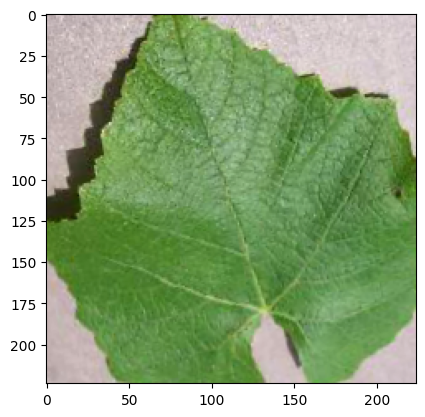

In [29]:
image = [i for i in files if '.png' in i][0] # get first image found
img = Image.open(image)
plt.imshow(img)

In [30]:
print("Original image size:", img.size)  # (width, height)
print("Mode:", img.mode)  # 'RGB' or 'L' (grayscale)

Original image size: (224, 224)
Mode: RGB


This data set is a bit non-traditional: usually there are separate Training and Testing folders, with subfolders of images per class. Nevertheless, we will use keras' ImageDataGenerator to prepare our image dataset.

In [31]:
# set training data path
train_path = path+"/Final Training Data/"

In [32]:
# create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation - since there is no separate Test image data
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [33]:
# then separate your data into training and validation sets
# the ImageDataGenerator will handle shuffling and number of channels
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224), # only specify height and width
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224), # only specify height and width
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 9600 images belonging to 4 classes.
Found 2400 images belonging to 4 classes.


Let's now train a CNN with 2 Conv blocks. 

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(224,224,3)), # conv block 1
    keras.layers.MaxPooling2D(2,2), # pool layer

    keras.layers.Conv2D(64,(3,3),activation="relu"), # conv block 2
    keras.layers.MaxPooling2D(2,2), # pool layer

    keras.layers.Flatten(), # dense nn
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(train_generator.num_classes,activation="softmax")
])

In [36]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - accuracy: 0.8035 - loss: 0.5878 - val_accuracy: 0.8913 - val_loss: 0.2814
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 211ms/step - accuracy: 0.9058 - loss: 0.2772 - val_accuracy: 0.9100 - val_loss: 0.2338
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - accuracy: 0.9287 - loss: 0.2054 - val_accuracy: 0.9467 - val_loss: 0.1662
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - accuracy: 0.9494 - loss: 0.1543 - val_accuracy: 0.9375 - val_loss: 0.1853
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - accuracy: 0.9528 - loss: 0.1430 - val_accuracy: 0.9296 - val_loss: 0.2013


Always plot the training and testing loss values per epoch to ensure no overfitting occurs. 

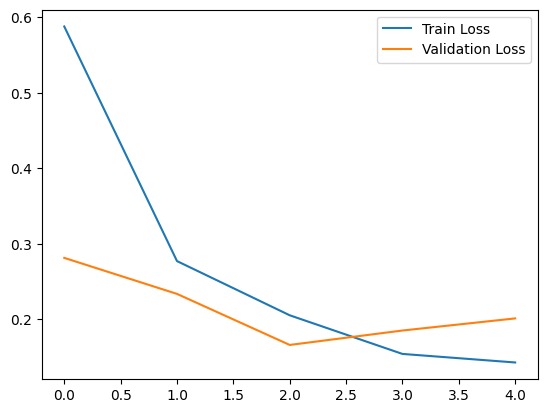

In [37]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

We can also check out some predictions the model makes on the validation set. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


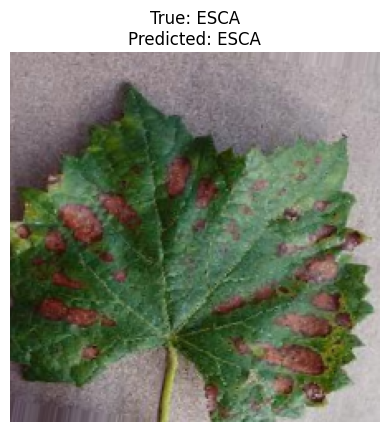

In [38]:
images, labels = next(val_generator) # we specified 32 as batch size so next() will give us 32 images
predictions = model.predict(images)

# Get predicted class indices
predicted_class_indices = predictions.argmax(axis=1) # get which class received highest probability

# Get class labels from the generator
class_labels = list(val_generator.class_indices.keys())

plt.imshow(images[0])
plt.axis('off')
true_label = class_labels[labels[0].argmax()]
pred_label = class_labels[predicted_class_indices[0]]
plt.title(f"True: {true_label}\nPredicted: {pred_label}")
plt.show()

We can also save our model to use it later. 

In [119]:
model.save("./models/grape_disease_CNN.keras")

Next time you load this model, it will be termed as "pretrained". That is, its weights have already been optimized to solve the problem of classifying disease in grape leaves. 

#### Transfer Learning

We can already see that even a simple architecture takes a long time to train for high resolution images. If we were to create an even deeper model, the training time will be significantly high. 

We can instead leverage Transfer Learning, which is a powerful way to train a neural network faster and more accurately. All you need to do are the following steps:
- Identify a pretrained model that solves a similar problem (in this case we will use a classification model trained on images)
- Next, remove its top/final layer - we want it to classify our classes instead
- Freeze its weights - the weights of this model are already optimized to identify edges/patterns
- Add a custom layer on top that feeds into your desired output shape
- Train only the top layers 

In [17]:
# we will use Mobile Net v2 already available in keras
from tensorflow.keras.applications import MobileNetV2

In [18]:
IMG_SHAPE = (224, 224, 3)  # match target_size and RGB images

# Load base MobileNetV2 model, without the top classifier layer
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

In [39]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Removing the top layer removes all layers after the last convolution block. So we will add a Dense hidden layer first. Traditionally, we flatten the last conv block but for transfer learning, we will use Global Average Pooling (averages entire feature maps into a single value). Note that there are 1280 feature maps in the last conv block, so applying Flatten may not be a good idea. 

In [123]:
# Freeze the base model so it doesn't update during training
base_model.trainable = False

In [ ]:
tl_model = keras.models.Sequential([
    base_model,
    ...
    ])

This now resembles a traditional CNN with several conv blocks and a fully connected layer feeding into the output layer. Because we froze the base model, the weights in those layers will not change. Instead, only the weights between the last conv block and our fully connected layer will update. 

In [125]:
tl_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = tl_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

These large pretrained models provide a quick way of creating a model to solve a specific problem. In this instance, the original model was built to classify images (1000 unique classes). Now, we have used its pre-existing weights and some quick training of later layers to predict for our classes. 

If you want to, you can also unfreeze the earlier layers in the network to tune those layers to your input data. This will be significantly slower, but may improve your model's performance. 

In [ ]:
# Unfreeze top layers of base model
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)